# Code Demo For Visualizing of Landscape
This file shows the basic implementation of how to visualize the landscape of LLMs conditioned on specific question w.r.t the answer

In [8]:
import os
from collections import defaultdict
import random
random.seed(42)

from tqdm import tqdm
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import json
import pandas as pd
import numpy as np
from matplotlib.lines import Line2D

### Preparation

load tokenizer

In [4]:
tokenizer = AutoTokenizer.from_pretrained("Qwen/QwQ-32B")

load AIME24 data

In [5]:
dataset = load_dataset("HuggingFaceH4/aime_2024", split="train")

load model

In [6]:
model = AutoModelForCausalLM.from_pretrained(
    "Qwen/QwQ-32B", 
    trust_remote_code=True, 
    torch_dtype="bfloat16",
    attn_implementation="flash_attention_2", 
    device_map="auto"
)
model.eval()

Loading checkpoint shards: 100%|██████████| 14/14 [00:29<00:00,  2.12s/it]


Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(152064, 5120)
    (layers): ModuleList(
      (0-63): 64 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): Linear(in_features=5120, out_features=5120, bias=True)
          (k_proj): Linear(in_features=5120, out_features=1024, bias=True)
          (v_proj): Linear(in_features=5120, out_features=1024, bias=True)
          (o_proj): Linear(in_features=5120, out_features=5120, bias=False)
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=5120, out_features=27648, bias=False)
          (up_proj): Linear(in_features=5120, out_features=27648, bias=False)
          (down_proj): Linear(in_features=27648, out_features=5120, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((5120,), eps=1e-05)
        (post_attention_layernorm): Qwen2RMSNorm((5120,), eps=1e-05)
      )
    )
    (norm): Qwen2RMSNorm((5120,), eps=1e-05)
    (rotary_emb

## Generate Losslandscape
please also refer to https://arxiv.org/abs/1712.09913

### construct inputs of LLM

In [13]:
prompt_template = "{question}\n\nPlease reason step by step, and put your final answer within \\boxed{{}}"
messages = [
    {"role": "user", "content": prompt_template.format(question=dataset[0]["problem"])}
]

instruction_tokens = tokenizer.encode(tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=False))
answer_tokens = tokenizer.encode(dataset[0]["answer"])
inputs = tokenizer.encode_plus(
    tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=False) + \
        "\n\n**Final Answer**\n\\boxed{" + dataset[0]["answer"], add_special_tokens=False, return_tensors="pt")

### Generate random vectors

In [9]:
direction1, direction2 = {}, {}
for n, p in tqdm(model.named_parameters()):
    if n in ["lm_head.weight", "model.embed_tokens.weight"]:
        continue
    direction1[n] = torch.randn_like(p).cpu()
    direction2[n] = torch.randn_like(p).cpu()

for (n, p) in tqdm(model.named_parameters()):
    if n in ["lm_head.weight", "model.embed_tokens.weight"]:
        continue
    norm_p = torch.linalg.norm(p.cpu().flatten())
    direction1[n].div_(torch.linalg.norm(direction1[n].cpu().flatten()).to(direction1[n])).mul_(norm_p.to(direction1[n]))
    direction2[n].div_(torch.linalg.norm(direction2[n].cpu().flatten()).to(direction2[n])).mul_(norm_p.to(direction2[n]))

771it [01:00, 12.80it/s]
771it [01:05, 11.72it/s]


### Generate Landscape

Initialize coordinates, a simple demo, you can increase density

In [15]:
x = np.linspace(-1, 1, 10)
y = np.linspace(-1, 1, 10)
X, Y = np.meshgrid(x, y)
Z = np.zeros_like(X)

manipulate parameters to generate landscape

In [16]:
for x_idx in tqdm(range(x.size), desc="x progress"):
    for y_idx in tqdm(range(y.size), desc="y progress", leave=False):
        for n, p in model.named_parameters():
            if n in ["lm_head.weight", "model.embed_tokens.weight"]:
                continue
            p.data.add_(x[x_idx]*direction1[n].to(p) + y[y_idx]*direction2[n].to(p))
        
        outputs = model(**inputs, labels=inputs["input_ids"])
        logits = outputs.logits[:, :-1, :][0, -len(answer_tokens):, :]
        scores = torch.softmax(logits, dim=-1)
        loss = 0.0
        for indice, idx in enumerate(answer_tokens):
            loss += -torch.log(scores[indice, idx])
        loss /= len(answer_tokens)
        Z[x_idx, y_idx] = loss.item()
        
        for n, p in model.named_parameters():
            if n in ["lm_head.weight", "model.embed_tokens.weight"]:
                continue
            p.data.sub_(x[x_idx]*direction1[n].to(p) + y[y_idx]*direction2[n].to(p))

x progress: 100%|██████████| 10/10 [45:46<00:00, 274.67s/it]


### Visualize Landscape

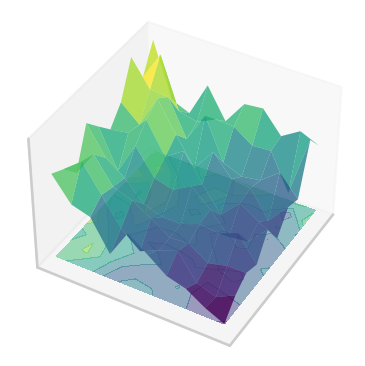

In [26]:
plt.rcParams['font.family'] = 'Maple Mono'
plt.rcParams['font.weight'] = 'normal'

sns.set_theme(style="whitegrid")
sns.set_context("talk")

fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(X, Y, Z, cmap='viridis', linewidth=0, antialiased=True, alpha=0.8) 
cset = ax.contourf(X, Y, Z, zdir='z', offset=np.min(Z), cmap='viridis', alpha=0.5) 
ax.view_init(elev=40, azim=30) 
ax.grid(False) 
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
plt.tight_layout() 
plt.show() 